In [6]:
%matplotlib inline
import matplotlib as mplt 
from matplotlib import cm 
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
import matplotlib 
from matplotlib.ticker import FuncFormatter 
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

import statsmodels as sm 
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf 
from statsmodels.tsa.api import VAR, DynamicVAR
from statsmodels.stats import diagnostic

from utils_libs import *
from utils_data_prep import * 

from mixture import *

In [7]:
# ---- set-up ----

# ---- MAE
def eval_mae(df):
    
    diff = df['truth'] - df['pre']
    return mean( abs(diff) )


# ---- MAPE
def eval_mape(df):
    
    diff = df['truth'] - df['pre']
#   ?
    tmp = abs(diff/(df['truth']+1e-10))

    tmpsum = []
    for i in range(len(tmp)):
        if abs(df['truth'].iloc[i])>1e-5:
            tmpsum.append( tmp[i] )
                    
    return mean(tmpsum)

# ---- RMSE
def eval_rmse(df):
    
    diff = np.asarray((df['truth']-df['pre']))
    splits = np.split(diff, 5, 0)
    
#     return sqrt(mean(diff**2))
    
    split_rmse = []
    for i in splits:
        split_rmse.append( sqrt( mean(i**2) ) )
        
        
    return [mean(split_rmse), std(split_rmse)]
    
# ---- ACCURACY
col_format_mix = ['truth', 'pre', 'pre_v', 'pre_b']
col_format_gate = ['vol', 'ob']
col_format = ['truth', 'pre']

features_ob = ['Spread', 'Weightd spread', 'Ask vol.', 'Bid vol.', 'Vol. diff.', 'Ask depth', 'Bid depth', \
               'Depth diff.', 'Bid slope', 'Ask slope']

models = [ 'garch', 'egarch', 'str', 'arima', 'arimax', 'strx', 'gbt', 'rf', 'xgt', 'enet', 'gp' ]
# 'arima', arimax', 'lasso', 'str', 'strx', 'garch', 'egarch'
# 'bayes', 'ewma',

file_path = "../bt_results/res/rolling/"

pre_ts = 'pytest_'
pre_tr = 'pytrain_'

gate_ts = 'gate_test'
gate_tr = 'gate_train'

post_txt = '.txt'
post_dat = '.dat'

weight_pre = '_weight_pre_mix'
weight_gate = '_weight_gate_mix'

bin_bound = []
for i in range(50):
    bin_bound.append(i*0.02)

# ---- Significance test

# Paired data: Wilcoxon signed-rank test, paired Student's t-test 

# Sample data: ks-test, sample mean test

In [3]:
# STEP GAP Sample
    
def sample_gap_result(interval, segments, file_path):
    # plot
    fig, ax = plt.subplots(4, figsize=(6.3,16))
#     fig.suptitle("Time interval " + str(interval), fontsize = 15)
    plot_idx = 0
    
    for tmp_gate in [0, 1, 2, 3]:
        
        file_name = str(interval) + '_' +  str(tmp_gate) + '_' + pre_ts + 'mix' + post_txt
        df = pd.read_csv( file_path + file_name, sep=',', names = col_format_mix)
    
        ax[plot_idx].plot(range(segments[1]-segments[0]), df['truth'].iloc[segments[0]: segments[1]], \
                          label = 'truth',\
                         marker='o',)
        
        delta = tmp_gate+1
        ax[plot_idx].plot( [j-delta for j in range(segments[1]-segments[0])], df['pre'].iloc[segments[0] : segments[1] ], \
                          label = ' prediction', \
                          marker='o', linewidth = 2)
        ax[plot_idx].legend()
        
        ax[plot_idx].set_xlabel('Time', fontweight = 'bold')
        ax[plot_idx].set_ylabel('Volatility', fontweight = 'bold')
        
        ax[plot_idx].text(1, 0.9, r'$\Delta$ = '+str(tmp_gate+1), fontsize=16)
#         ax[plot_idx].set_title(r'$\lambda$')

        plot_idx += 1
        
    fig.savefig('../bt_results/res/pics/sample/gap_sample.pdf', bbox_inches='tight')
    
sample_gap_result(9, [600, 700], file_path)

In [2]:
# STEP GAP Plot

for tmp_inter in range(2,19):
    
    # plot
    fig, ax = plt.subplots(4, figsize=(19,8))
    fig.suptitle("Time interval " + str(tmp_inter), fontsize = 15)
    plot_idx = 0
    
    
    for tmp_gate in [0, 1, 2, 3]:
        
        file_name = str(tmp_inter) + '_' +  str(tmp_gate) + '_' + pre_ts + 'mix' + post_txt
        df = pd.read_csv( file_path + file_name, sep=',', names = col_format_mix)
    
        cnt = 100
        tmpl = 400
        tmpr = 500
        
        ax[plot_idx].plot( range(tmpr-tmpl), df['truth'].iloc[tmpl:tmpr], label = 'truth',  marker='o')
        ax[plot_idx].plot( range(tmpr-tmpl), df['pre'].iloc[tmpl+(tmp_gate+1) :tmpr+(tmp_gate+1)], label = ' pre', \
                          marker='o')
        ax[plot_idx].legend()
        

        plot_idx += 1
        
    fig.savefig('../bt_results/res/pics/sample/full_sample.pdf', bbox_inches='tight')

In [ ]:
# prediction and truth Plot

for tmp_inter in range(2,19):
    
    # plot
    fig, ax = plt.subplots(4, figsize=(19,8))
    fig.suptitle("Time interval " + str(tmp_inter), fontsize = 15)
    plot_idx = 0
    
    
    for tmp_gate in [0, 1, 2, 3]:
        
        file_name = str(tmp_inter) + '_' +  str(tmp_gate) + '_' + pre_ts + 'mix' + post_txt
        df = pd.read_csv( file_path + file_name, sep=',', names = col_format_mix)
    
        ax[plot_idx].plot(df['truth'], label = 'truth')
        ax[plot_idx].plot(df['pre'], label = ' pre')
        ax[plot_idx].legend()
        

        plot_idx += 1

In [ ]:
# statitiscal test on gate weight 

for i in range(2,14):
    
    print ' --- interval ', i-1, ': ' 
    
    # gates in training
    file_name = str(i) + '_' + gate_tr + post_txt
    df_tr = pd.read_csv( file_path + file_name, sep=',', names = col_format_gate )
    
    # gates in testing
    file_name = str(i) + '_' + gate_ts + post_txt
    df_ts = pd.read_csv( file_path + file_name, sep=',', names = col_format_gate )
    
    
    print 'Adfuller test:\n', sm.tsa.stattools.adfuller( df_tr['vol'] , regression='c', maxlag=None, store=False)
    print 'KPSS test:\n', sm.tsa.stattools.kpss( df_tr['vol'],\
                                            regression='c', \
                                    lags=None, store=False)
    

In [11]:
# Prediction errors 

# print ' --- RMSE'
# # RMSE
# for i in range(2,14):
    
#     tmp_rmse = []
    
#     file_name = str(i) + '_' + pre_ts + 'mix' + post_txt
#     df = pd.read_csv( file_path + file_name, sep=',', names = col_format_mix)
    
#     # component error
#     tmp_rmse.append( eval_rmse(df) )
# #     tmp_rmse.append( sqrt(mean((df['truth']-df['pre_v'])**2)) )
# #     tmp_rmse.append( sqrt(mean((df['truth']-df['pre_b'])**2)) )
# #     tmp_rmse.append( '  ' )
    
    
#     for tmp_mdl in models:
        
#         file_name = str(i) + '_' + pre_ts + tmp_mdl + post_txt
#         df = pd.read_csv( file_path + file_name, sep=',', names = col_format)
        
#         tmp_rmse.append( eval_rmse(df) )
        
#     print 'interval ', i-1, ': ', tmp_rmse
    

# print '\n --- MAPE'
# # MAPE
# for i in range(2,14):
    
#     tmp_mape = []
    
#     file_name = str(i) + '_' + pre_ts + 'mix' + post_txt
#     df = pd.read_csv( file_path + file_name, sep=',', names = col_format_mix)
    
#     tmp_mape.append( eval_mape(df) )
    
#     for tmp_mdl in models:
        
#         file_name = str(i) + '_' + pre_ts + tmp_mdl + post_txt
#         df = pd.read_csv( file_path + file_name, sep=',', names = col_format)
        
#         tmp_mape.append( eval_mape(df) )
        
#     print 'interval ', i-1, ': ', tmp_mape
    

    
models = [ 'ewma', 'garch', 'egarch', 'str','arima', 'arimax', 'strx', 'gbt', 'rf', 'xgt', 'enet', 'gp' ]
# 'arima', arimax', 'lasso', 'str', 'strx', 'garch', 'egarch'
# 'bayes', 'ewma',
file_path = "../bt_results/res/rolling/incre/"


print '\n --- MAE'
# MAPE
for i in range(7,19):
    
    tmp_mae = []
    
    file_name = str(i) + '_' + pre_ts + 'mix' + post_txt
    df = pd.read_csv( file_path + file_name, sep=',', names = col_format_mix)
    
    tmp_mae.append( eval_mae(df) )
#     tmp_mae.append( mean(abs(df['truth']-df['pre_v'])) )
#     tmp_mae.append( mean(abs(df['truth']-df['pre_b'])) )
#     tmp_mae.append( '  ' )
    
    for tmp_mdl in models:
        
        file_name = str(i) + '_' + pre_ts + tmp_mdl + post_txt
        df = pd.read_csv( file_path + file_name, sep=',', names = col_format)
        
        tmp_mae.append( eval_mae(df) )
        
    print 'interval ', i-6, ': ', tmp_mae

    


 --- MAE
interval  1 :  [0.04416361199764302, 0.046593670464372544, 0.0981372659546453, 0.09327503590442683, 0.05523615555036872, 0.05667389155255804, 0.05844497924090903, 12.67926354376913, 0.0480338184300421, 0.04719155912490462, 0.04396208047306292, 0.04615032738176255, 0.04645537602851418]
interval  2 :  [0.06123427659063743, 0.06342372833085697, 0.13273611258999857, 0.1288551390186487, 0.09079274636503833, 0.09016674730516075, 0.09752332445180503, 6.8181469788822495, 0.06689688170307721, 0.07226233268528924, 0.06264883584221315, 0.063447596192226, 0.06430353973982988]
interval  3 :  [0.15010357538881142, 0.1577947814213725, 0.33117025524447, 0.32687770512551456, 0.2711002004182357, 0.25684109049916326, 0.2731277690872139, 5.758765868794881, 0.15793898103062556, 0.1673332385641095, 0.154532559339098, 0.1496891887727247, 0.15386981028631827]
interval  4 :  [0.0715629484215825, 0.07496416773585254, 0.147155699986007, 0.14245991352517556, 0.13957758884750016, 0.11674698792527127, 0.1

In [4]:
# statitiscal test on look-back horizon


models = [ 'arimax', 'strx', 'gbt', 'rf', 'xgt', 'enet', 'gp' ]
# 'arima', arimax', 'lasso', 'str', 'strx', 'garch', 'egarch'
# 'bayes', 'ewma',
horizons = ['10minu/', '20minu/', '40minu/', '50minu/']

file_path = "../bt_results/res/rolling/"

for h in horizons: 
    
    tmp_path = file_path + h
    
    print ' --- horizon ', h, ': ' 
    
    file_name = str(7) + '_' + pre_ts + 'mix' + post_txt
    df = pd.read_csv( tmp_path + file_name, sep=',', names = col_format_mix)
    
    mix_resi = np.asarray( df['truth']-df['pre'] )
    
    print sqrt(mean(mix_resi*mix_resi)) 

    
    for tmp_mdl in models:
        
        file_name = str(7) + '_' + pre_ts + tmp_mdl + post_txt
        df = pd.read_csv( tmp_path + file_name, sep=',', names = col_format)
        
        tmp_resi = np.asarray( df['truth']-df['pre'] )
        
        print  tmp_mdl, ':', stats.ks_2samp( np.asarray(mix_resi), np.asarray(tmp_resi) ),\
        sqrt(mean(tmp_resi*tmp_resi)) 

        


 --- horizon  10minu/ : 
0.0759778917903
arimax : Ks_2sampResult(statistic=0.39228826728826721, pvalue=5.1210010323294336e-49) 0.111380477398
strx : Ks_2sampResult(statistic=0.95530303030303032, pvalue=1.3839838333194833e-288) 4.3478631282
gbt : Ks_2sampResult(statistic=0.05694444444444445, pvalue=0.18759606160154418) 0.0803009649448
rf : Ks_2sampResult(statistic=0.11388888888888887, pvalue=0.00015532544947514631) 0.0791857941976
xgt : Ks_2sampResult(statistic=0.10416666666666669, pvalue=0.00072939748568807278) 0.0760850725467
enet : Ks_2sampResult(statistic=0.059722222222222232, pvalue=0.14815720928544085) 0.0786948005903
gp : Ks_2sampResult(statistic=0.054166666666666669, pvalue=0.23478504425172381) 0.0800012042031
 --- horizon  20minu/ : 
0.0763606591325
arimax : Ks_2sampResult(statistic=0.42447552447552445, pvalue=2.5605347583121149e-57) 0.124644495908
strx : Ks_2sampResult(statistic=0.96511266511266514, pvalue=1.5586284592404394e-294) 6.0856925181
gbt : Ks_2sampResult(statistic=0.

In [9]:
# statitiscal test on prediction errors  

file_path = "../bt_results/res/rolling/roll/"

for i in range(7,19):
    
    print ' --- interval ', i-6, ': ' 
    
    file_name = str(i) + '_' + pre_ts + 'mix' + post_txt
    df = pd.read_csv( file_path + file_name, sep=',', names = col_format_mix)
    
    mix_resi = np.asarray( df['truth']-df['pre'] )

#   while noise test    
#     print 'mix', stats.kstest(np.asarray( df['truth']-df['pre'] ), 'norm')
#     print 'mix', stats.mstats.normaltest(np.asarray( df['truth']-df['pre'] ))
#     print 'mix', sm.stats.diagnostic.acorr_ljungbox(np.asarray( df['truth']-df['pre']),\
#                                                     lags = 5, boxpierce=False)[1]
    
    
    for tmp_mdl in models:
        
        file_name = str(i) + '_' + pre_ts + tmp_mdl + post_txt
        df = pd.read_csv( file_path + file_name, sep=',', names = col_format)
        
        tmp_resi = np.asarray( df['truth']-df['pre'] )
        
        print  tmp_mdl, ':', stats.ks_2samp( np.asarray(mix_resi), np.asarray(tmp_resi) )

        
#   while noise test
#         print tmp_mdl, sm.stats.diagnostic.acorr_ljungbox(np.asarray( df['truth']-df['pre']), \
#                                                         lags = 5, boxpierce=False)[1]
#         print tmp_mdl, stats.mstats.normaltest(np.asarray( df['truth']-df['pre'] ))
#         print tmp_mdl, stats.kstest(np.asarray( df['truth']-df['pre'] ), 'norm')

 --- interval  1 : 
ewma : Ks_2sampResult(statistic=0.2513888888888889, pvalue=1.8928837842434105e-20)
garch : Ks_2sampResult(statistic=0.7067404817404818, pvalue=3.860957959906266e-158)
egarch : Ks_2sampResult(statistic=0.6912490287490287, pvalue=2.6606127971656485e-151)
str : Ks_2sampResult(statistic=0.3659576534576534, pvalue=1.0314384687175543e-42)
arima : Ks_2sampResult(statistic=0.32218337218337223, pvalue=3.348996861552978e-33)
arimax : Ks_2sampResult(statistic=0.3849261849261849, pvalue=3.281578894126891e-47)
strx : Ks_2sampResult(statistic=0.9567307692307693, pvalue=1.9017532818602857e-289)
gbt : Ks_2sampResult(statistic=0.12916666666666668, pvalue=1.0343323869357034e-05)
rf : Ks_2sampResult(statistic=0.2027777777777778, pvalue=1.872585675940014e-13)
xgt : Ks_2sampResult(statistic=0.16944444444444443, pvalue=1.5986568809706579e-09)
enet : Ks_2sampResult(statistic=0.26388888888888895, pvalue=1.7230113220406978e-22)
gp : Ks_2sampResult(statistic=0.1166666666666667, pvalue=9.7346

In [ ]:
# top-k features over intervals

# weight[0] vol temporal, [1] vol bias, [2] order book temporal, [3] order book feature, [4] bias 

# features_ob = [ 'spread', 'weightd spread', 'ask vol.', 'bid vol.', 'vol. diff.', 'ask depth', 'bid depth', \
#                'depth diff.', 'bid slope', 'ask slope']

for i in range(7, 19):
    
    print '-- interval ', i
    
    # DATA
    file_name = str(i) + weight_pre + post_dat
    tmp_weight = np.load(file_path + file_name)
    
    
#     np.abs(np.flip(np.squeeze(tmp_weight[0]),0)) )
#     np.abs(np.flip(np.squeeze(tmp_weight[2]),0)) )
    
    ft_weight = list(zip(features_ob, np.abs(np.squeeze(tmp_weight[3]))))
    
    tmp = sorted(ft_weight, key = lambda x: x[1], reverse = True)
    print tmp[:3]
    
    file_name = str(i) + weight_gate + post_dat
    tmp_weight = np.load(file_path + file_name)
    
#     np.abs(np.flip(np.squeeze(tmp_weight[0]),0)) )
#     np.abs(np.flip(np.squeeze(tmp_weight[2]),0)) )
    
    ft_weight = list(zip(features_ob, np.abs(np.squeeze(tmp_weight[3]))))
    
    tmp = sorted(ft_weight, key = lambda x: x[1], reverse = True)
    print tmp[:3]
    
    print '\n'


In [ ]:
# parameter distribution of mixture expert

# weight[0] vol temporal, [1] vol bias, [2] order book temporal, [3] order book feature, [4] bias 

vol_temp = []
ob_temp = []
ob_ft = []

for i in range(2,14):
    # DATA
    file_name = str(i) + weight_pre + post_dat
    tmp_weight = np.load(file_path + file_name)
    
    vol_temp.append( np.flip(np.squeeze(tmp_weight[0]),0) )
    ob_temp.append( np.flip(np.squeeze(tmp_weight[2]),0) )
    ob_ft.append( np.squeeze(tmp_weight[3]) )
    
     # PLOT 
    fig, ax_list = plt.subplots(1, 3, figsize=(15,4))
    fig.suptitle("Time interval " + str(i-1), fontsize = 15)
    
    ax_list[0].bar(range(len(np.squeeze(tmp_weight[0]))), np.abs(np.flip(np.squeeze(tmp_weight[0]),0)) )
    ax_list[0].set_title('Auto-regressive volatility')
    ax_list[0].set(xlabel='Temporal lags', ylabel='weights')
    ax_list[0].set_ylim(0,0.2)
    
    ax_list[1].bar(range(len(np.squeeze(tmp_weight[2]))), np.abs(np.flip(np.squeeze(tmp_weight[2]),0)) )
    ax_list[1].set_title('Temporal dependency on order book')
    ax_list[1].set(xlabel='Temporal lags')
    ax_list[1].set_ylim(0,0.5)
    
    ax_list[2].bar( range(len(np.squeeze(tmp_weight[3])) ), np.abs(np.squeeze(tmp_weight[3])) )
    ax_list[2].set_title('Feature dependency on order book')
    tmp_ind = range(len(np.squeeze(tmp_weight[3])))
    plt.xticks( tmp_ind , features_ob, rotation=50 )
    ax_list[2].set_ylim(0,0.15)
    
    plt.subplots_adjust(top=0.85)
    
print np.shape(vol_temp), np.shape(ob_temp), np.shape(ob_ft)

fig, ax = plt.subplots(figsize=(10,3))
ax.plot(np.abs(vol_temp));

fig, ax = plt.subplots(figsize=(10,3))
ax.plot(np.abs(ob_temp));

fig, ax = plt.subplots(figsize=(10,3))
ax.plot(np.abs(ob_ft));

#    


In [ ]:
# parameter distribution of mixture gate

# weight[0] vol temporal, [1] vol bias, [2] order book temporal, [3] order book feature, [4] bias 

vol_temp = []
ob_temp = []
ob_ft = []

for i in range(2,14):
    
    # DATA
    file_name = str(i) + weight_gate + post_dat
    tmp_weight = np.load(file_path + file_name)
    
    vol_temp.append( np.flip(np.squeeze(tmp_weight[0]),0) )
    ob_temp.append( np.flip(np.squeeze(tmp_weight[2]),0) )
    ob_ft.append( np.squeeze(tmp_weight[3]) )
    
    # PLOT 
    fig, ax_list = plt.subplots(1, 3, figsize=(15,4))
    fig.suptitle("Time interval " + str(i-1), fontsize = 15)
    
    ax_list[0].bar(range(len(np.squeeze(tmp_weight[0]))), np.abs(np.flip(np.squeeze(tmp_weight[0]),0)) )
    ax_list[0].set_title('Auto-regressive volatility')
    ax_list[0].set(xlabel='Temporal lags', ylabel='weights')
    ax_list[0].set_ylim(0,0.5)
    
    ax_list[1].bar(range(len(np.squeeze(tmp_weight[2]))), np.abs(np.flip(np.squeeze(tmp_weight[2]),0)) )
    ax_list[1].set_title('Temporal dependency on order book')
    ax_list[1].set(xlabel='Temporal lags')
    ax_list[1].set_ylim(0,0.5)
    
    ax_list[2].bar( range(len(np.squeeze(tmp_weight[3])) ), np.abs(np.squeeze(tmp_weight[3])) )
    ax_list[2].set_title('Feature dependency on order book')
    tmp_ind = range(len(np.squeeze(tmp_weight[3])))
    plt.xticks( tmp_ind , features_ob, rotation=50 )
    ax_list[2].set_ylim(0, 1.0)
    
    plt.subplots_adjust(top=0.85)
    
print np.shape(vol_temp), np.shape(ob_temp), np.shape(ob_ft)

fig, ax = plt.subplots(figsize=(10,3))
ax.plot(np.abs(vol_temp));

fig, ax = plt.subplots(figsize=(10,3))
ax.plot(np.abs(ob_temp));

fig, ax = plt.subplots(figsize=(10,3))
ax.plot(np.abs(ob_ft));

#    


In [ ]:
# gate and volatility correlation

# TO DO: LOOK INTO THE FUTURE OF VOLATILITY

for i in range(2,14):
    
    # truth in training 
    file_name = str(i) + '_' + pre_tr + 'mix' + post_txt
    df = pd.read_csv( file_path + file_name, sep=',', names = col_format_mix)
    y_tr = list(df['truth'])
    
    # truth in testing
    file_name = str(i) + '_' + pre_ts + 'mix' + post_txt
    df = pd.read_csv( file_path + file_name, sep=',', names = col_format_mix)
    y_ts = list(df['truth'])
    
    # gates in training
    file_name = str(i) + '_' + gate_tr + post_txt
    df_tr = pd.read_csv( file_path + file_name, sep=',', names = col_format_gate )
    
    # gates in testing
    file_name = str(i) + '_' + gate_ts + post_txt
    df_ts = pd.read_csv( file_path + file_name, sep=',', names = col_format_gate )
    
    # ?
    gate_ob = list(df_ts['ob'])
    up_idx = []
    for j in range(1, len(gate_ob)):
        if 1.0*(gate_ob[j]-gate_ob[j-1])/gate_ob[j-1] > 0.9:
            up_idx.append(j)
    cnt = 0
    for k in up_idx:
        # ?
        if k-1>=0 and y_ts[k]>y_ts[k-1]:
            cnt+=1
        
    print 1.0*cnt/len(up_idx)    
        
    

In [ ]:
# testing data  gate hist, prediction, gate series

for i in range(2, 19):
    
    
    # -- DATA
    
    # DATA truth in testing  
    file_name = str(i) + '_' + pre_ts + 'mix' + post_txt
    df_pre = pd.read_csv( file_path + file_name, sep=',', names = col_format_mix)
    
    # DATA gates in testing
    file_name = str(i) + '_' + gate_ts + post_txt
    df_gate = pd.read_csv( file_path + file_name, sep=',', names = col_format_gate )
    tmp_gate = np.asarray(df_gate)
    
    # -- PLOT
    
    fig, ax = plt.subplots(1, 3, figsize=(15,3))
    fig.suptitle("Time interval " + str(i-6), fontsize = 15)
    
    # hist
    ax[0].hist(df_gate['ob'], histtype='bar', bins = bin_bound,  \
               label='Gate distribution of order book \n in the testing data ')
    ax[0].set_ylim(0,300)
    ax[0].legend(fontsize=10)
    
    # truth and prediction
    ax[1].plot(df_pre['truth'], label = 'Truth')
    ax[1].plot(df_pre['pre'], label = 'Prediction')
    ax[1].plot(df_pre['pre_v'], label = 'Pre_v')
    ax[1].plot(df_pre['pre_b'], label = 'Pre_b')
    ax[1].legend()
    ax[1].set_ylim(0,2)
    
    # gate distribution
    X = range(len(tmp_gate))
    Y =  [1.0 for k in tmp_gate ]
    Y1 = [k[0] for k in tmp_gate]
    Y2 = [0.0 for k in tmp_gate]
    
    ax[2].plot(Y, label = 'Order book', color='k', alpha=.5)
    ax[2].plot(Y1,label = 'Volatility', color = 'k', alpha=.1)
    ax[2].plot(Y2,)
    ax[2].fill_between(X, Y, Y1, color='k',alpha=.5)
    ax[2].fill_between(X, Y1,Y2, color='y',alpha=.5)
    

In [ ]:
# conditional gate distribution  TESTING

for i in range(2,19):
    
    # --- DATA
    
    # DATA truth target values in testing 
    file_name = str(i) + '_' + pre_ts + 'mix' + post_txt
    df_pre = pd.read_csv( file_path + file_name, sep=',', names = col_format_mix)
    pre_v = list(df_pre['pre_v'])
    pre_ob = list(df_pre['pre_b'])
    pre = list(df_pre['pre'])
    
    # DATA gates in testing
    file_name = str(i) + '_' + gate_ts + post_txt
    df_gate = pd.read_csv( file_path + file_name, sep=',', names = col_format_gate )
    tmp_gate = np.asarray(df_gate)
    
    gate_ob = list( df_gate['ob'] )
    
    # DATA feature data
    data_path = "../dataset/bitcoin/training_data/rolling/" + str(i) + "_xtest_mix" + post_dat
    x = np.load(data_path)
    
    data_path = "../dataset/bitcoin/training_data/rolling/" + str(i) + "_ytest_mix" + post_dat
    y = np.load(data_path)
    
    # DATA gate parameters
    file_name = str(i) + weight_gate + post_dat
    gate_para = np.load(file_path + file_name)
    abs_gate_para = np.abs(gate_para) 
    
    # DATA expert parameters
    file_name = str(i) + weight_pre + post_dat
    exp_para = np.load(file_path + file_name)
    
    
    # conditional distribution
    win = 20
    win_median = np.median(y[:win])
    win_std = std(y[:win])
    
    tmpup = []
    tmplow= []
    tmpmid = []
    
    diff_y = []
    diff_g = []
    
    tmpvol = []
    
    

#     (tmp_gate[k][1]-tmp_gate[k-1][1])*1.0/tmp_gate[k-1][1]
    
    
    tmp = [ [],[] ]
    
    for k in range(1, len(y)):
        
        tmpmean = np.median( pre_v[k-10:k] )
        tmpstd = std( pre_v[k-10:k] )
        
        
#         if gate_ob[k]>0.4:
#             if abs(y[k])>1e-5:
#                 tmp[0].append(  abs(y[k]-y[k-1])*1.0/y[k] )
        
        
#         elif gate_ob[k]<0.1:
#             if abs(y[k])>1e-5:
#                 tmp[1].append(  abs(y[k]-y[k-1])*1.0/y[k] )
                
        
        if gate_ob[k]>0.4:
            if abs(y[k])>1e-5:
                tmp[0].append(  abs(y[k]-y[k-1])*1.0/y[k] )
        
        
        elif gate_ob[k]<0.1:
            if abs(y[k])>1e-5:
                tmp[1].append(  abs(y[k]-y[k-1])*1.0/y[k] )
            
        
    print '--- interval ', i-6, ' : ', len(tmp[0]), np.median(tmp[0]), np.median(tmp[1])
    
#     , len(tmpup)   
#     std(tmpup), mean(tmplow), std(tmplow), len(tmpup), len(tmplow)
    
#     print test    

In [ ]:
# investigation into each interval

# TESTING

import matplotlib.backends.backend_pdf


plt.ioff()
    
for i in range(2,19):
    
    # --- DATA
    
    # DATA truth target values in testing 
    file_name = str(i) + '_' + pre_ts + 'mix' + post_txt
    df_pre = pd.read_csv( file_path + file_name, sep=',', names = col_format_mix)
    
    # DATA gates in testing
    file_name = str(i) + '_' + gate_ts + post_txt
    df_gate = pd.read_csv( file_path + file_name, sep=',', names = col_format_gate )
    tmp_gate = np.asarray(df_gate)
    
    
    # DATA feature data
    data_path = "../dataset/bitcoin/training_data/rolling/" + str(i) + "_xtest_mix" + post_dat
    x = np.load(data_path)
    
    data_path = "../dataset/bitcoin/training_data/rolling/" + str(i) + "_ytest_mix" + post_dat
    y = np.load(data_path)
    
    # DATA gate parameters
    file_name = str(i) + weight_gate + post_dat
    gate_para = np.load(file_path + file_name)
    abs_gate_para = np.abs(gate_para) 
    
    # DATA expert parameters
    file_name = str(i) + weight_pre + post_dat
    exp_para = np.load(file_path + file_name)
    abs_exp_para = np.abs(exp_para) 
    
# #   TO DO
#     # DATA minute data
#     data_path = "../dataset/bitcoin/training_data/rolling_minu/" + str(i) + "_train_mix" + post_dat
#     price_minu_tr = np.load(data_path)
    
#     data_path = "../dataset/bitcoin/training_data/rolling_minu/" + str(i) + "_test_mix" + post_dat
#     price_minu_ts = np.load(data_path)
#     print np.shape(price_minu_tr), np.shape(price_minu_ts)
    
    
    
    # auto-regressive volatility, features 
    vol = np.asarray( [k[0] for k in x] )
    ob  = np.asarray( [k[1] for k in x] )
    print np.shape(vol), np.shape(ob)
    
    # feature first
#     ob = np.transpose(ob, [2, 0, 1])
#     print  np.shape(ob)
    
    # data instances with certain gates 
    pos = []
    for j in range(len(tmp_gate)):
        if tmp_gate[j][1] >= 0.0 and tmp_gate[j][1] <= 1.0:
            pos.append(j)
    num = len(pos)
    
    # sample
    np.random.shuffle(pos)
    if num<100:
        cnt_sample = num
    else:
        cnt_sample = 100
    
    vol_sample = vol[pos[:cnt_sample]]
    ob_sample = ob[pos[:cnt_sample]]
    
    # feature first
    ob_sample = np.transpose(ob_sample, [2, 0, 1])
    
    
    # --- PLOT
    
    
    fig, ax = plt.subplots(6, 3, figsize=(15,15))
    fig.suptitle("Time interval " + str(i-6), fontsize = 15)
    
    # hist
    ax[0][0].hist(df_gate['ob'], histtype='bar', bins = bin_bound,  \
               label='Gate distribution of order book \n in the testing data ')
    ax[0][0].set_ylim(0,300)
    ax[0][0].legend(fontsize=10)
    
    # truth and prediction
    ax[0][1].plot(df_pre['truth'], label = 'Truth')
    ax[0][1].plot(df_pre['pre'],   label = 'Prediction', linewidth = 4)
    ax[0][1].plot(df_pre['pre_v'], label = 'pre_v')
    ax[0][1].plot(df_pre['pre_b'],   label = 'pre_b')
    ax[0][1].set_ylim([0.0, 3.0])
    ax[0][1].legend()
    
    
    # gate distribution
    X = range(len(tmp_gate))
    Y =  [1.0 for k in tmp_gate ]
    Y1 = [k[0] for k in tmp_gate]
    Y2 = [0.0 for k in tmp_gate]
    
    ax[0][2].plot(Y, label = 'Order book', color='k', alpha=.5)
    ax[0][2].plot(Y1,label = 'Volatility', color = 'k', alpha=.1)
    ax[0][2].plot(Y2,)
    ax[0][2].fill_between(X, Y, Y1, color='k',alpha=.5)
    ax[0][2].fill_between(X, Y1,Y2, color='y',alpha=.5)
    
    
    # features
    print  'order book', np.shape(ob)
    ob = np.transpose(ob, [2, 1, 0])
    
    
    max_ob = np.max(ob[0], 0)
    min_ob = np.min(ob[0], 0)
    ax[1][0].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[1][0].set_ylim([0,10])
    ax[1][0].set_title(features_ob[0])
    
    max_ob = np.max(ob[1], 0)
    min_ob = np.min(ob[1], 0)
    ax[1][1].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[1][1].set_ylim([0,10])
    ax[1][1].set_title(features_ob[1])
    
    max_ob = np.max(ob[2], 0)
    min_ob = np.min(ob[2], 0)
    ax[1][2].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[1][2].set_ylim([0,350])
    ax[1][2].set_title(features_ob[2])
    
    
    max_ob = np.max(ob[3], 0)
    min_ob = np.min(ob[3], 0)
    ax[2][0].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[2][0].set_ylim([0,500])
    ax[2][0].set_title(features_ob[3])
    
    max_ob = np.max(ob[4], 0)
    min_ob = np.min(ob[4], 0)
    ax[2][1].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[2][1].set_ylim([-200,200])
    ax[2][1].set_title(features_ob[4])
    
    max_ob = np.max(ob[5], 0)
    min_ob = np.min(ob[5], 0)
    ax[2][2].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[2][2].set_ylim([0,5000])
    ax[2][2].set_title(features_ob[5])
    
    
    max_ob = np.max(ob[6], 0)
    min_ob = np.min(ob[6], 0)
    ax[3][0].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[3][0].set_ylim([0,5000])
    ax[3][0].set_title(features_ob[6])
    
    max_ob = np.max(ob[7], 0)
    min_ob = np.min(ob[7], 0)
    ax[3][1].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[3][1].set_ylim([-4000,4000])
    ax[3][1].set_title(features_ob[7])
    
    max_ob = np.max(ob[8], 0)
    min_ob = np.min(ob[8], 0)
    ax[3][2].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[3][2].set_ylim([0,2000])
    ax[3][2].set_title(features_ob[8])
    
    
    max_ob = np.max(ob[9], 0)
    min_ob = np.min(ob[9], 0)
    ax[4][0].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[4][0].set_ylim([0,2000])
    ax[4][0].set_title(features_ob[9])
    
    
    # price at minutes
#     ax[4][1].plot(price_minu_ts)
#     ax[4][1].set_title('Temporal dependency on order book')
#     ax[4][1].set(xlabel='Temporal lags')
#     ax[4][1].set_ylim([200, 800])
    
    # temporal weights of gate
    handler = ax[4][1].bar( range(len(np.squeeze(abs_gate_para[2])) ), np.squeeze(abs_gate_para[2]))
    ax[4][1].set_title('Temporal weight of gate')
    tmp_ind = range(len(np.squeeze(abs_gate_para[3])))
    ax[4][1].set_ylim([0, 1.0])
    plt.xticks( tmp_ind , features_ob, rotation=50 )
    
    # feature weights of gate
    handler = ax[4][2].bar( range(len(np.squeeze(abs_gate_para[3])) ), np.squeeze(abs_gate_para[3]))
    ax[4][2].set_title('Feature weight of gate')
    tmp_ind = range(len(np.squeeze(abs_gate_para[3])))
    ax[4][2].set_ylim([0, 1.0])
    plt.xticks( tmp_ind , features_ob, rotation=50 )
    
    
    # temporal weights of gate
    handler = ax[5][1].bar( range(len(np.squeeze(abs_exp_para[2])) ), np.squeeze(abs_exp_para[2]))
    ax[5][1].set_title('Temporal weight of prediction')
    tmp_ind = range(len(np.squeeze(abs_exp_para[3])))
    ax[5][1].set_ylim([0, 1.0])
    plt.xticks( tmp_ind , features_ob, rotation=50 )
    
    # feature weights of gate
    handler = ax[5][2].bar( range(len(np.squeeze(abs_exp_para[3])) ), np.squeeze(abs_exp_para[3]))
    ax[5][2].set_title('Feature weight of prediction')
    tmp_ind = range(len(np.squeeze(abs_exp_para[3])))
    ax[5][2].set_ylim([0, 0.5])
    plt.xticks( tmp_ind , features_ob, rotation=50 )
    
    
    # save figure
    fig.subplots_adjust(hspace=0.3)
    plt.subplots_adjust(top=0.95)
    fig.savefig('../bt_results/res/pics/test_' + str(i-6) + '.jpeg', bbox_inches='tight')
    plt.close()
    

In [65]:
sample_extraction( 2, [300, 420], 2 )

# 18, [0, 120], 0
#  17, [400, 520], 0
#  16, [80, 200], 0
#  15, [600, 720], 0
#  13, [600, 720], 0
#  13, [0, 120], 1
# 12, [0, 120], 0
# 11, [500, 620], 0
#  10, [500, 620], 0
# 9, [100, 220], 0
# 9, [600, 720], 1
# 8, [400, 520], 0
# 8, [300, 420], 1 

# 7, [250, 370], 0
# 6, [300, 420], 0
# 6, [450, 570], 1
# 5, [400, 520], 0
# 5, [150, 270], 1
# 5, [600, 720], 2
# 3, [200, 320], 0
# 2, [0, 120], 0 
# 2, [100, 220], 1 
# 2, [300, 420], 2

(121, 16) (121, 30, 10)
order book (121, 30, 10)


In [ ]:
# post-effect on volatility patten after different order book weights 

for i in range(2,14):
    
    # --- DATA
    
    # DATA truth target values in testing 
    file_name = str(i) + '_' + pre_tr + 'mix' + post_txt
    df_pre = pd.read_csv( file_path + file_name, sep=',', names = col_format_mix)
    
    # DATA gates in testing
    file_name = str(i) + '_' + gate_tr + post_txt
    df_gate = pd.read_csv( file_path + file_name, sep=',', names = col_format_gate )
    tmp_gate = np.asarray(df_gate)
    
    # DATA feature data
    data_path = "../dataset/bitcoin/training_data/rolling/" + str(i) + "_xtrain_mix" + post_dat
    x = np.load(data_path)
    
    data_path = "../dataset/bitcoin/training_data/rolling/" + str(i) + "_ytrain_mix" + post_dat
    y = np.load(data_path)
    
    # DATA gate parameters
    file_name = str(i) + weight_gate + post_dat
    gate_para = np.load(file_path + file_name)
    
    abs_gate_para = np.abs(gate_para) 
    
    # DATA expert parameters
    file_name = str(i) + weight_pre + post_dat
    exp_para = np.load(file_path + file_name)
    
    # DATA minute data
    data_path = "../dataset/bitcoin/training_data/rolling_minu/" + str(i) + "_train" + post_dat
    price_minu_tr = np.load(data_path)
    
    data_path = "../dataset/bitcoin/training_data/rolling_minu/" + str(i) + "_test" + post_dat
    price_minu_ts = np.load(data_path)
#     print np.shape(price_minu_tr), np.shape(price_minu_ts)
    
    # auto-regressive volatility, features 
    vol = np.asarray( [k[0] for k in x] )
    ob  = np.asarray( [k[1] for k in x] )
    print np.shape(x), np.shape(y), np.shape(vol), np.shape(ob)
    
    # feature first
#     ob = np.transpose(ob, [2, 0, 1])
#     print  np.shape(ob)
    
    # data instances with certain gates 
    pos = []
    for j in range(len(tmp_gate)):
        if tmp_gate[j][1] >= 0.4 and tmp_gate[j][1] <= 1.0:
            pos.append(j)
    num = len(pos)
    
    # sample
    np.random.shuffle(pos)
    if num<100:
        cnt_sample = num
    else:
        cnt_sample = 100
    
    
    #----     
    tmplen   = 10
    subseq_y = []
    for i in range(cnt_sample):
        if pos[i] + tmplen < len(y):
            subseq_y.append( y[pos[i]:pos[i]+tmplen] )
    
    subseq_y = np.asarray(subseq_y)
    vsample = vol[pos[:cnt_sample]]
    dsample = ob[pos[:cnt_sample]]
    print np.shape(vsample), np.shape(dsample)
    
    if np.shape(vsample)[0]==0:
        continue


    # plot auto-regressive and subsequent volatility
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,5))
    # fig.set_size_inches( 18,7 )
    ax1.boxplot(vsample);
    ax1.set_ylim(0,1.6)
    
    ax2.boxplot(subseq_y);
    ax2.set_ylim(0,1.6)
    

In [ ]:
# post-effect on volatility patten after different order book weights 

for i in range(2,14):
    
    # --- DATA
    
    # DATA truth target values in testing 
    file_name = str(i) + '_' + pre_tr + 'mix' + post_txt
    df_pre = pd.read_csv( file_path + file_name, sep=',', names = col_format_mix)
    
    # DATA gates in testing
    file_name = str(i) + '_' + gate_tr + post_txt
    df_gate = pd.read_csv( file_path + file_name, sep=',', names = col_format_gate )
    tmp_gate = np.asarray(df_gate)
    
    # DATA feature data
    data_path = "../dataset/bitcoin/training_data/rolling/" + str(i) + "_xtrain_mix" + post_dat
    x = np.load(data_path)
    
    data_path = "../dataset/bitcoin/training_data/rolling/" + str(i) + "_ytrain_mix" + post_dat
    y = np.load(data_path)
    
    # DATA gate parameters
    file_name = str(i) + weight_gate + post_dat
    gate_para = np.load(file_path + file_name)
    
    abs_gate_para = np.abs(gate_para) 
    
    # DATA expert parameters
    file_name = str(i) + weight_pre + post_dat
    exp_para = np.load(file_path + file_name)
    
    # DATA minute data
    data_path = "../dataset/bitcoin/training_data/rolling_minu/" + str(i) + "_train" + post_dat
    price_minu_tr = np.load(data_path)
    
    data_path = "../dataset/bitcoin/training_data/rolling_minu/" + str(i) + "_test" + post_dat
    price_minu_ts = np.load(data_path)
#     print np.shape(price_minu_tr), np.shape(price_minu_ts)
    
    # auto-regressive volatility, features 
    vol = np.asarray( [k[0] for k in x] )
    ob  = np.asarray( [k[1] for k in x] )
    print np.shape(x), np.shape(y), np.shape(vol), np.shape(ob)
    
    # feature first
#     ob = np.transpose(ob, [2, 0, 1])
#     print  np.shape(ob)
    
    # data instances with certain gates 
    pos = []
    for j in range(len(tmp_gate)):
        if tmp_gate[j][1] >= 0.0 and tmp_gate[j][1] <= 0.3:
            pos.append(j)
    num = len(pos)
    
    # sample
    np.random.shuffle(pos)
    if num<40:
        cnt_sample = num
    else:
        cnt_sample = 40
        
#     cnt_sample = num
    
    #----     
    tmplen   = 10
    subseq_y = []
    for i in range(cnt_sample):
        if pos[i] + tmplen < len(y):
            subseq_y.append( y[pos[i]:pos[i]+tmplen] )
    
    subseq_y = np.asarray(subseq_y)
    vsample = vol[pos[:cnt_sample]]
    dsample = ob[pos[:cnt_sample]]
    print np.shape(vsample), np.shape(dsample)
    
    if np.shape(vsample)[0]==0:
        continue


    # plot auto-regressive and subsequent volatility
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,5))
    # fig.set_size_inches( 18,7 )
    ax1.boxplot(vsample);
    ax1.set_ylim(0,1.6)
    
    ax2.boxplot(subseq_y);
    ax2.set_ylim(0,1.6)
    

In [39]:
# sample a segment

# TESTING

import matplotlib.backends.backend_pdf
plt.ioff()
    
    
def sample_extraction( interval, segment, seg_num ):    
    
    i = interval 
    segl = segment[0]
    segr = segment[1]
    
    # --- DATA
    
    # DATA truth target values in testing 
    file_name = str(i) + '_' + pre_ts + 'mix' + post_txt
    df_pre = pd.read_csv( file_path + file_name, sep=',', names = col_format_mix)
    
    df_pre = df_pre.iloc[segl:segr+1]
    
    # DATA gates in testing
    file_name = str(i) + '_' + gate_ts + post_txt
    df_gate = pd.read_csv( file_path + file_name, sep=',', names = col_format_gate )
    tmp_gate = np.asarray(df_gate)
    
    tmp_gate = tmp_gate[segl:segr+1] 
    
    # DATA feature data
    data_path = "../dataset/bitcoin/training_data/rolling/" + str(i) + "_xtest_mix" + post_dat
    x = np.load(data_path)[segl:segr+1]
    
    data_path = "../dataset/bitcoin/training_data/rolling/" + str(i) + "_ytest_mix" + post_dat
    y = np.load(data_path)[segl:segr+1]
    
    # DATA gate parameters
    file_name = str(i) + weight_gate + post_dat
    gate_para = np.load(file_path + file_name)
    abs_gate_para = np.abs(gate_para)
    
    # DATA expert parameters
    file_name = str(i) + weight_pre + post_dat
    exp_para = np.load(file_path + file_name)
    abs_exp_para = np.abs(exp_para)
    
# #   TO DO
#     # DATA minute data
#     data_path = "../dataset/bitcoin/training_data/rolling_minu/" + str(i) + "_train_mix" + post_dat
#     price_minu_tr = np.load(data_path)
    
#     data_path = "../dataset/bitcoin/training_data/rolling_minu/" + str(i) + "_test_mix" + post_dat
#     price_minu_ts = np.load(data_path)
#     print np.shape(price_minu_tr), np.shape(price_minu_ts)
    
    
    # auto-regressive volatility, features 
    vol = np.asarray( [k[0] for k in x] )
    ob  = np.asarray( [k[1] for k in x] )
    print np.shape(vol), np.shape(ob)
    
    
    # --- PLOT
    
    fig, ax = plt.subplots(6, 3, figsize=(15,15))
    fig.suptitle("Time interval " + str(i-6), fontsize = 15)
    
    # hist
    ax[0][0].hist(df_gate['ob'], histtype='bar', bins = bin_bound,  \
               label='Gate distribution of order book \n in the testing data ')
    ax[0][0].set_ylim(0,300)
    ax[0][0].legend(fontsize=10)
    
    
    # truth and prediction
    ax[0][1].plot(df_pre['truth'], label = 'Truth')
    ax[0][1].plot(df_pre['pre'],   label = 'Prediction', linewidth = 4)
    ax[0][1].plot(df_pre['pre_v'], label = 'pre_v')
    ax[0][1].plot(df_pre['pre_b'],   label = 'pre_b')
    ax[0][1].set_ylim([0.0, 3.0])
#     ax[0][1].legend(loc=0)
    
    
    # gate distribution
    X = range(len(tmp_gate))
    Y =  [1.0 for k in tmp_gate ]
    Y1 = [k[0] for k in tmp_gate]
    Y2 = [0.0 for k in tmp_gate]
    
    ax[0][2].plot(Y, label = 'Order book', color='k', alpha=.5)
    ax[0][2].plot(Y1,label = 'Volatility', color = 'k', alpha=.1)
    ax[0][2].plot(Y2,)
    ax[0][2].fill_between(X, Y, Y1, color='k',alpha=.5)
    ax[0][2].fill_between(X, Y1,Y2, color='y',alpha=.5)
    
    
    # features
    print  'order book', np.shape(ob)
    ob = np.transpose(ob, [2, 1, 0])
    
    
    max_ob = np.max(ob[0], 0)
    min_ob = np.min(ob[0], 0)
    ax[1][0].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[1][0].set_ylim([0,10])
    ax[1][0].set_title(features_ob[0])
    
    max_ob = np.max(ob[1], 0)
    min_ob = np.min(ob[1], 0)
    ax[1][1].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[1][1].set_ylim([0,10])
    ax[1][1].set_title(features_ob[1])
    
    max_ob = np.max(ob[2], 0)
    min_ob = np.min(ob[2], 0)
    ax[1][2].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[1][2].set_ylim([0,350])
    ax[1][2].set_title(features_ob[2])
    
    
    max_ob = np.max(ob[3], 0)
    min_ob = np.min(ob[3], 0)
    ax[2][0].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[2][0].set_ylim([0,500])
    ax[2][0].set_title(features_ob[3])
    
    max_ob = np.max(ob[4], 0)
    min_ob = np.min(ob[4], 0)
    ax[2][1].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[2][1].set_ylim([-200,200])
    ax[2][1].set_title(features_ob[4])
    
    max_ob = np.max(ob[5], 0)
    min_ob = np.min(ob[5], 0)
    ax[2][2].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[2][2].set_ylim([0,5000])
    ax[2][2].set_title(features_ob[5])
    
    
    max_ob = np.max(ob[6], 0)
    min_ob = np.min(ob[6], 0)
    ax[3][0].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[3][0].set_ylim([0,5000])
    ax[3][0].set_title(features_ob[6])
    
    max_ob = np.max(ob[7], 0)
    min_ob = np.min(ob[7], 0)
    ax[3][1].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[3][1].set_ylim([-4000,4000])
    ax[3][1].set_title(features_ob[7])
    
    max_ob = np.max(ob[8], 0)
    min_ob = np.min(ob[8], 0)
    ax[3][2].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[3][2].set_ylim([0,2000])
    ax[3][2].set_title(features_ob[8])
    
    
    max_ob = np.max(ob[9], 0)
    min_ob = np.min(ob[9], 0)
    ax[4][0].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[4][0].set_ylim([0,2000])
    ax[4][0].set_title(features_ob[9])
    
    
    # price at minutes
#     ax[4][1].plot(price_minu_ts)
#     ax[4][1].set_title('Temporal dependency on order book')
#     ax[4][1].set(xlabel='Temporal lags')
#     ax[4][1].set_ylim([200, 800])
    
    # temporal weights of gate
    handler = ax[4][1].bar( range(len(np.squeeze(abs_gate_para[2])) ), \
                           np.squeeze(abs_gate_para[2]))
    ax[4][1].set_title('Temporal weight of gate')
    tmp_ind = range(len(np.squeeze(abs_gate_para[3])))
    ax[4][1].set_ylim([0, 1.0])
    plt.xticks( tmp_ind , features_ob, rotation=50 )
    
    # feature weights of gate
    handler = ax[4][2].bar( range(len(np.squeeze(abs_gate_para[3])) ), \
                           np.squeeze(abs_gate_para[3]))
    ax[4][2].set_title('Feature weight of gate')
    tmp_ind = range(len(np.squeeze(abs_gate_para[3])))
    ax[4][2].set_ylim([0, 1.0])
    plt.xticks( tmp_ind , features_ob, rotation=50 )
    
    
    # temporal weights of gate
    handler = ax[5][1].bar( range(len(np.squeeze(abs_exp_para[2])) ), \
                           np.squeeze(abs_exp_para[2]))
    ax[5][1].set_title('Temporal weight of prediction')
    tmp_ind = range(len(np.squeeze(abs_exp_para[3])))
    ax[5][1].set_ylim([0, 1.0])
    plt.xticks( tmp_ind , features_ob, rotation=50 )
    
    # feature weights of gate
    handler = ax[5][2].bar( range(len(np.squeeze(abs_exp_para[3])) ),\
                           np.squeeze(abs_exp_para[3]))
    ax[5][2].set_title('Feature weight of prediction')
    tmp_ind = range(len(np.squeeze(abs_exp_para[3])))
    ax[5][2].set_ylim([0, 0.5])
    plt.xticks( tmp_ind , features_ob, rotation=50 )
    
    
    # save figure
    fig.subplots_adjust(hspace=0.3)
    plt.subplots_adjust(top=0.95)
    fig.savefig('../bt_results/res/pics/sample/sample_' + str(i-6) + '_' + str(seg_num) +  '.jpeg', \
                bbox_inches='tight')
    plt.close()

    


(120, 16) (120, 30, 10)
------ test (120,)
(120, 16) (120, 30, 10)
------ test (120,)
(120, 16) (120, 30, 10)
------ test (120,)
(120, 16) (120, 30, 10)
------ test (120,)
(120, 16) (120, 30, 10)
------ test (120,)
(120, 16) (120, 30, 10)
(120, 16) (120, 30, 10)
(120, 16) (120, 30, 10)
(120, 16) (120, 30, 10)
(120, 16) (120, 30, 10)


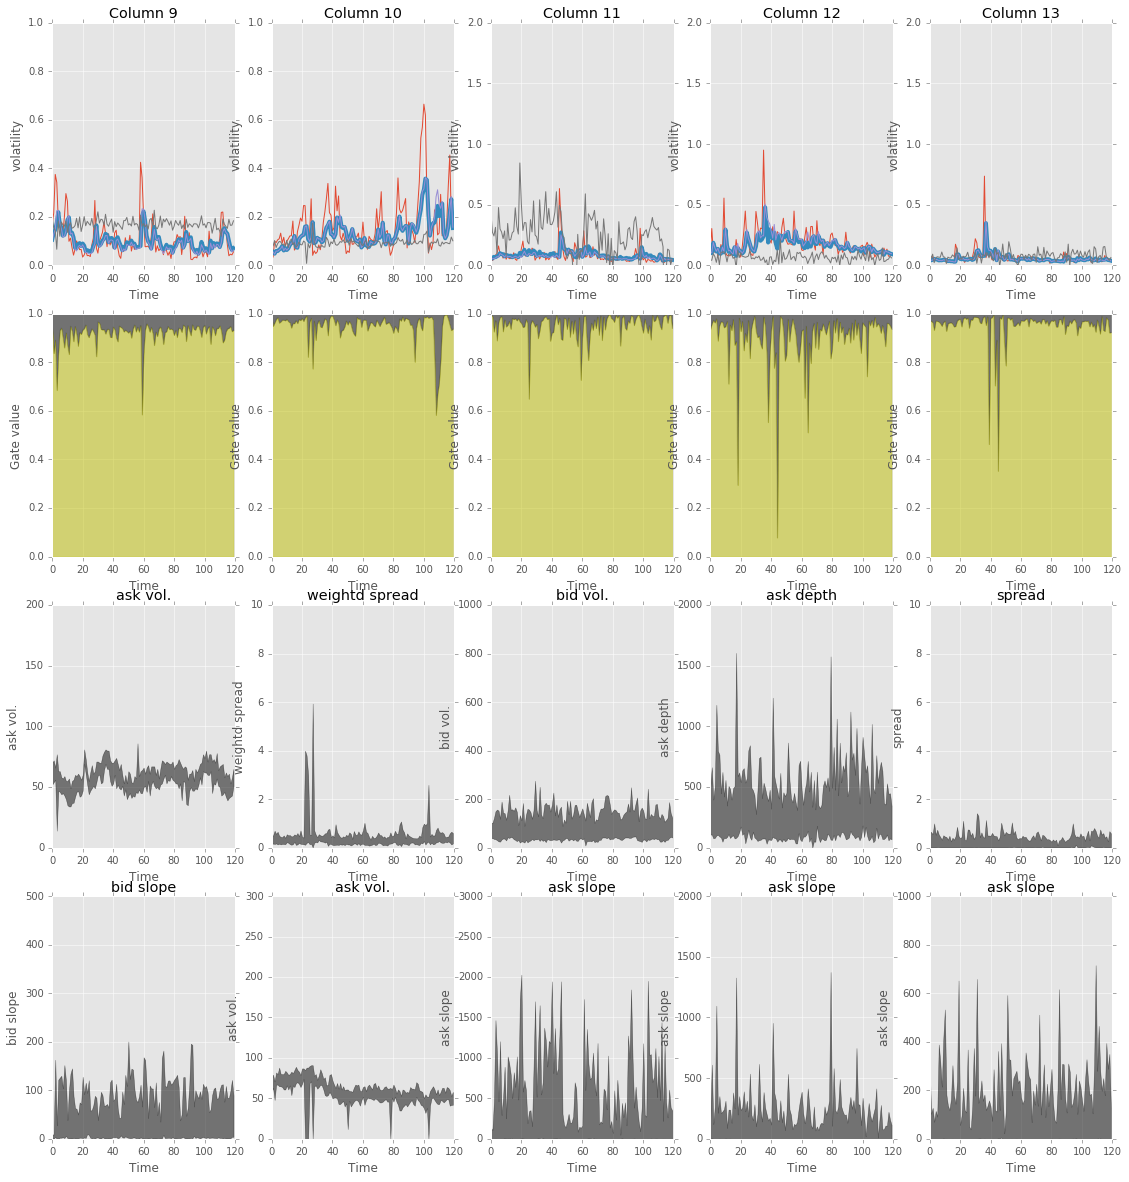

In [80]:
# Sample group

# 18, [0, 120], 0
#  17, [400, 520], 0
#  16, [80, 200], 0
#  15, [600, 720], 0
#  13, [600, 720], 0
#  13, [0, 120], 1
# 12, [0, 120], 0
# 11, [500, 620], 0
#  10, [500, 620], 0
# 9, [100, 220], 0
# 9, [600, 720], 1
# 8, [400, 520], 0
# 8, [300, 420], 1 

# 7, [250, 370], 0
# 6, [300, 420], 0
# 6, [450, 570], 1
# 5, [400, 520], 0
# 5, [150, 270], 1
# 5, [600, 720], 2
# 3, [200, 320], 0
# 2, [0, 120], 0 
# 2, [100, 220], 1 
# 2, [300, 420], 2

y_range = [1, 1, 2, 2, 2]
feature_range = [ [ [0,200],[0,500] ], [ [0,10], [0,300] ], [ [0,1000], [0,3000] ], \
                  [ [0,2000],[0,2000] ], [ [0,10],[0,1000] ] ]

sample_group( [ 6, 5, 3, 2, 2 ], [ [300,420], [600,720], [200,320], [100,220], [320,440]  ],\
              [ [2, 8], [1, 2], [3, 9], [5, 9], [0, 9] ], feature_range, y_range, range(9, 14) )

(120, 16) (120, 30, 10)
------ test (120,)
(120, 16) (120, 30, 10)
------ test (120,)
(120, 16) (120, 30, 10)
------ test (120,)
(120, 16) (120, 30, 10)
------ test (120,)
(120, 16) (120, 30, 10)
------ test (120,)
(120, 16) (120, 30, 10)
(120, 16) (120, 30, 10)
(120, 16) (120, 30, 10)
(120, 16) (120, 30, 10)
(120, 16) (120, 30, 10)


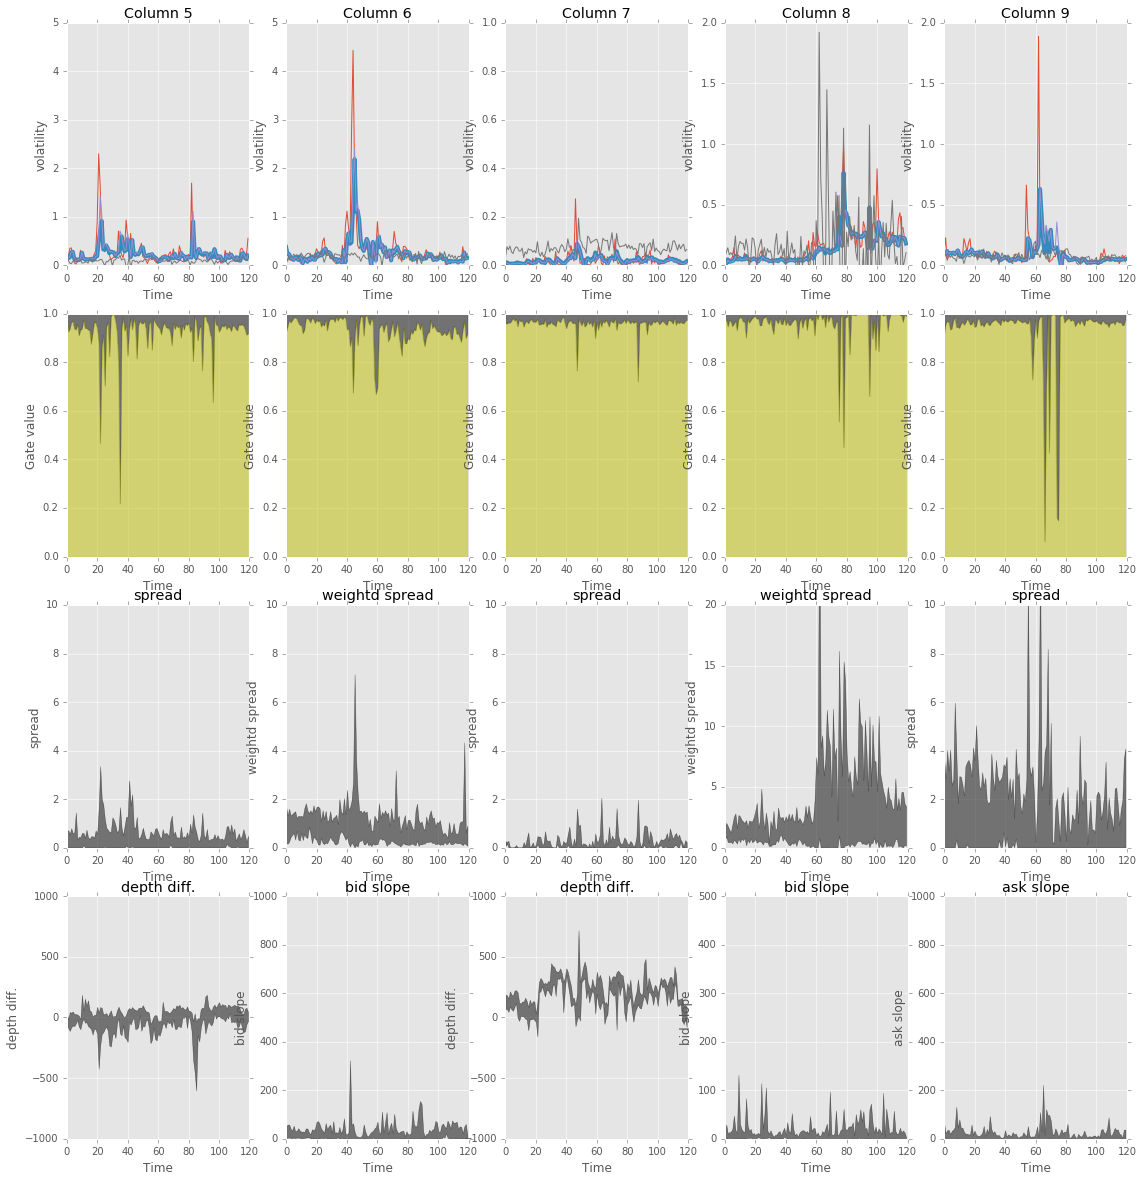

In [75]:
# Sample group

# 18, [0, 120], 0
#  17, [400, 520], 0
#  16, [80, 200], 0
#  15, [600, 720], 0
#  13, [600, 720], 0
#  13, [0, 120], 1
# 12, [0, 120], 0
# 11, [500, 620], 0
#  10, [500, 620], 0
# 9, [100, 220], 0
# 9, [600, 720], 1
# 8, [400, 520], 0
# 8, [300, 420], 1 

# 7, [250, 370], 0
# 6, [300, 420], 0
# 6, [450, 570], 1
# 5, [400, 520], 0
# 5, [150, 270], 1
# 5, [600, 720], 2
# 3, [200, 320], 0
# 2, [0, 120], 0 
# 2, [100, 220], 1 
# 2, [300, 420], 2

y_range = [5, 5, 1, 2, 2]
feature_range = [ [ [0,10], [-1000, 1000] ], [ [0,10], [0,1000] ], [ [0,10],[-1000,1000] ], \
                [ [0, 20], [0, 500] ], [ [0,10],[0, 1000] ] ]

sample_group( [ 9, 10, 13, 15, 18 ], [ [600, 720], [500, 620], [0, 120], [600, 720], [0, 120] ],\
              [ [0, 7], [1, 8], [0, 7], [1, 8], [0,9] ], feature_range, y_range, range(5, 10) ) 

(120, 16) (120, 30, 10)
------ test (120,)
(120, 16) (120, 30, 10)
------ test (120,)
(120, 16) (120, 30, 10)
------ test (120,)
(120, 16) (120, 30, 10)
------ test (120,)
(120, 16) (120, 30, 10)
------ test (120,)
(120, 16) (120, 30, 10)
(120, 16) (120, 30, 10)
(120, 16) (120, 30, 10)
(120, 16) (120, 30, 10)
(120, 16) (120, 30, 10)


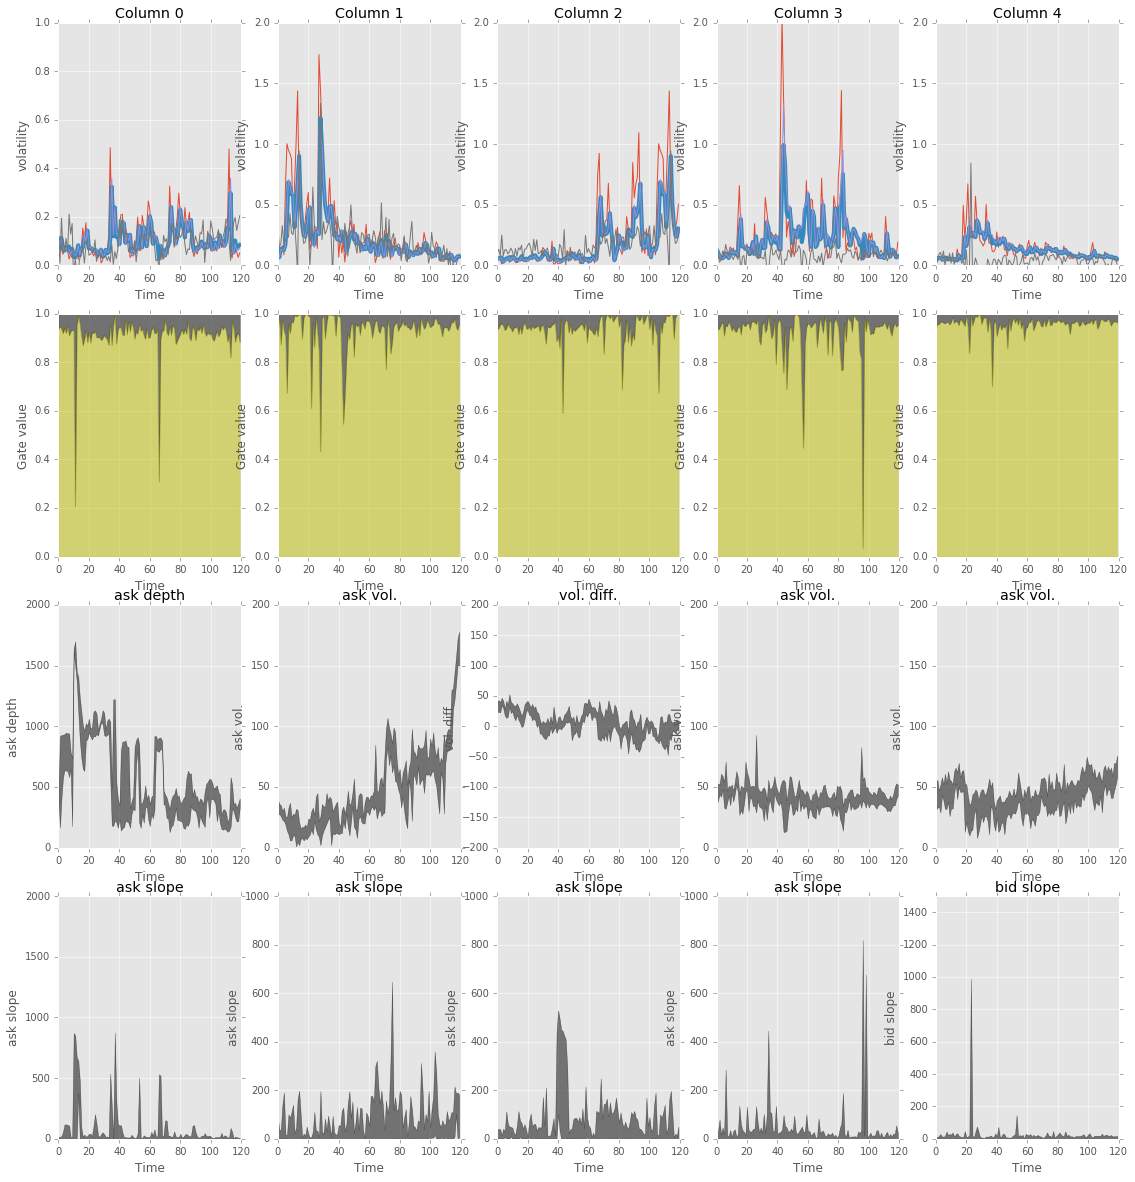

In [74]:
# Sample group

# 18, [0, 120], 0
#  17, [400, 520], 0
#  16, [80, 200], 0
#  15, [600, 720], 0
#  13, [600, 720], 0
#  13, [0, 120], 1
# 12, [0, 120], 0
# 11, [500, 620], 0
#  10, [500, 620], 0
# 9, [100, 220], 0
# 9, [600, 720], 1
# 8, [400, 520], 0
# 8, [300, 420], 1 

# 7, [250, 370], 0
# 6, [300, 420], 0
# 6, [450, 570], 1
# 5, [400, 520], 0
# 5, [150, 270], 1
# 5, [600, 720], 2
# 3, [200, 320], 0
# 2, [0, 120], 0 
# 2, [100, 220], 1 
# 2, [300, 420], 2

y_range = [1, 2, 2, 2, 2]
feature_range = [ [ [0,2000], [0, 2000] ], [ [0,200], [0,1000] ], [ [-200,200],[0,1000] ],\
                  [ [0,200], [0, 1000] ], [ [0,200], [0, 1500] ] ]

sample_group( [7, 8, 8, 9, 16], [ [250, 370], [400, 520], [300, 420], [100, 220], [80, 200] ],\
              [ [5, 9], [2, 9], [4, 9], [2, 9], [2, 8] ], feature_range, y_range, range(5) )

In [60]:
# Sample group

# sample plot
# TESTING

# feature_range = { 0:[0,10], 1:[0,10], 2:[0,350], 3:[0,350], 4:[-200, 200], \
#                 5:[0,3000], 6:[0,3000], 7:[-2000, 2000], 8:[0,1000], 9:[0,1000]}


file_path = "../bt_results/res/rolling/mixture_backup/"


def sample_group( intervals, segments, feature_ids, feature_range, y_range, cols ):    
    
    fig, ax = plt.subplots(4, len(intervals), figsize=(19,16))
    
    
    true_time = ['00:00AM, June, 20th, 2016', '08:00PM, July, 15th, 2016', '08:00PM, Dec., 17th, 2016' ]
    
#   Prediction and truth
    for k in range(len(intervals)):
        
        i = intervals[k]
        segl = segments[k][0]
        segr = segments[k][1]
        
        # DATA truth target values in testing 
        file_name = str(i) + '_' + pre_ts + 'mix' + post_txt
        df_pre = pd.read_csv( file_path + file_name, sep=',', names = col_format_mix)
        df_pre = df_pre.iloc[segl:segr]
        df_pre = df_pre.reset_index(drop=True)
        
        # truth and prediction
        ax[0][k].plot(df_pre['truth'], label = 'Truth')
        ax[0][k].plot(df_pre['pre'],   label = 'Prediction', linewidth = 4)
#         ax[0][k].plot(df_pre['pre_v'], label = 'pre_v')
#         ax[0][k].plot(df_pre['pre_b'],   label = 'pre_b')
        ax[0][k].set_ylim([0.0, y_range[k]])
        
#         ax[0][k].set_title('Column ' + str(cols[k]))
#         ax[0][k].set(xlabel='Time', ylabel='volatility')
        ax[0][k].legend(loc=0,  prop={'size': 15})
        
        ax[0][k].set_xlabel('Time offset [hour]', fontweight = 'bold', fontsize=12)
        ax[0][k].set_ylabel('Volatility', fontweight = 'bold', fontsize=12)
        
        ax[0][k].xaxis.set_tick_params(labelsize=12)
        ax[0][k].yaxis.set_tick_params(labelsize=12)
        
        
        ax[0][k].text(0.5, 4.6, true_time[k], fontsize=12)

        
#   Gate value over time  
    for k in range(len(intervals)):
        
        i = intervals[k]
        segl = segments[k][0]
        segr = segments[k][1]    
    
        # DATA gates in testing
        file_name = str(i) + '_' + gate_ts + post_txt
        df_gate = pd.read_csv( file_path + file_name, sep=',', names = col_format_gate )
        tmp_gate = np.asarray(df_gate)
        tmp_gate = tmp_gate[segl:segr] 
        
        # gate distribution
        X = range(len(tmp_gate))
        Y = [1.0 for j in tmp_gate ]
        Y1 = [j[0] for j in tmp_gate]
        Y2 = [0.0 for j in tmp_gate]
    
        ax[1][k].plot(Y, label = 'Order book', color='k', alpha=.5)
        ax[1][k].plot(Y1,label = 'Volatility', color = 'k', alpha=.1)
        ax[1][k].plot(Y2,)
        ax[1][k].fill_between(X, Y, Y1, color='k',alpha=.5)
        ax[1][k].fill_between(X, Y1,Y2, color='y',alpha=.5)
        
        ax[1][k].set_xlabel('Time offset [hour]', fontweight = 'bold',  fontsize=12)
        ax[1][k].set_ylabel('Gate value', fontweight = 'bold',  fontsize=12)
        
        ax[1][k].legend(loc=0,  prop={'size': 15})
        
        ax[1][k].xaxis.set_tick_params(labelsize=12)
        ax[1][k].yaxis.set_tick_params(labelsize=12)
    
#   Feature value  
    for k in range(len(intervals)):
        
        i = intervals[k]
        segl = segments[k][0]
        segr = segments[k][1] 
        
        # DATA feature data
        data_path = "../dataset/bitcoin/training_data/rolling/" + str(i) + "_xtest_mix" + post_dat
        x = np.load(data_path)[segl:segr]
    
        data_path = "../dataset/bitcoin/training_data/rolling/" + str(i) + "_ytest_mix" + post_dat
        y = np.load(data_path)[segl:segr]
    
        # auto-regressive volatility, features 
        vol = np.asarray( [j[0] for j in x] )
        ob  = np.asarray( [j[1] for j in x] )
        print np.shape(vol), np.shape(ob)
        
        ob = np.transpose(ob, [2, 1, 0])
        max_ob = np.max(ob[feature_ids[k][0]], 0)
        min_ob = np.min(ob[feature_ids[k][0]], 0)
        
        print '------ test', np.shape(X) 
        
        
        ax[2][k].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
        
        ax[2][k].set_ylim( feature_range[k][0] )
        
#         ax[2][k].set_title(features_ob[feature_ids[k][0]])
#         ax[2][k].set( xlabel='Time', ylabel = features_ob[feature_ids[k][0]] )
        
        ax[2][k].set_xlabel('Time offset [hour]', fontweight = 'bold', fontsize=12)
        ax[2][k].set_ylabel(features_ob[feature_ids[k][0]], fontweight = 'bold', fontsize=12)
        
        ax[2][k].xaxis.set_tick_params(labelsize=12)
        ax[2][k].yaxis.set_tick_params(labelsize=12)
    
    
    cols = ['(a)', '(b)', '(c)']
#   Feature value  
    for k in range(len(intervals)):
        
        i = intervals[k]
        segl = segments[k][0]
        segr = segments[k][1] 
        
        # DATA feature data
        data_path = "../dataset/bitcoin/training_data/rolling/" + str(i) + "_xtest_mix" + post_dat
        x = np.load(data_path)[segl:segr]
    
        data_path = "../dataset/bitcoin/training_data/rolling/" + str(i) + "_ytest_mix" + post_dat
        y = np.load(data_path)[segl:segr]
    
        # auto-regressive volatility, features 
        vol = np.asarray( [j[0] for j in x] )
        ob  = np.asarray( [j[1] for j in x] )
        print np.shape(vol), np.shape(ob)
        
        ob = np.transpose(ob, [2, 1, 0])
        max_ob = np.max(ob[feature_ids[k][1]], 0)
        min_ob = np.min(ob[feature_ids[k][1]], 0)
        ax[3][k].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
        
        ax[3][k].set_ylim(feature_range[k][1])
        
#         ax[3][k].set_title(features_ob[feature_ids[k][1]])
#         ax[3][k].set( xlabel='Time', ylabel = features_ob[feature_ids[k][1]] )
        
        ax[3][k].set_xlabel('Time offset [hour] \n ' + cols[k], fontweight = 'bold', fontsize=12)
        ax[3][k].set_ylabel(features_ob[feature_ids[k][1]], fontweight = 'bold', fontsize=12)
        
        ax[3][k].xaxis.set_tick_params(labelsize=12)
        ax[3][k].yaxis.set_tick_params(labelsize=12)
    
    fig.savefig('../bt_results/res/pics/sample/final_sample.pdf', bbox_inches='tight')

In [164]:
print len([9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4])
days_month = ([30, 31, 30, 31, 31, 30, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 30, 31, 30])

month_name = ['sep', 'oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'april', 'may', 'june', 'july', 'aug', 'sep', 'oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'april' ] 
# 13713, 13729,
print len(month_name) 

20
20


In [170]:
tmpsum = 0.0

for i in range( len(days_month) ):
    
    for k in global_hour:
        if k >= tmpsum and k <= tmpsum + ( days_month[i]*24 ):
            
            resi_hour = k-tmpsum 
            tmpday = resi_hour / 24
            tmphour= resi_hour%24
            
            print 'month', i, month_name[i], ', day: ', tmpday, ', hour: ', tmphour
    
    tmpsum += ( days_month[i]*24 )
    
print tmpsum

480.0 month 9 june , day:  20.0 , hour:  0.0
380.0 month 10 july , day:  15.8333333333 , hour:  20.0
428.0 month 15 dec , day:  17.8333333333 , hour:  20.0
14664.0


In [157]:
#  global hour
global_hour = [6480.0 + 600, 7200.0 + 500, 10800.0 + 620]
print global_hour

[7080.0, 7700.0, 11420.0]


In [156]:
# true date and time 

chosen_inter = [ 9, 10, 15 ]
chosen_seg   = [ [600, 700], [500, 600], [620, 720] ]

# set up the interval parameters
interval_len = 30*24
interval_num = int(13713/interval_len)
roll_len = 2
    
for i in range(roll_len + 1, interval_num+1):
    
    length = i*interval_len - (i-roll_len-1)*interval_len
    
    para_train_split_ratio = 1.0*(interval_len*roll_len)/length
    
    tmpl = (i-roll_len-1)*interval_len
    tmpr = i*interval_len
    
    print i-1, length, [ tmpl, tmpr  ], \
        [ tmpl + length*para_train_split_ratio, tmpr ] 


2 2160 [0, 2160] [1440.0, 2160]
3 2160 [720, 2880] [2160.0, 2880]
4 2160 [1440, 3600] [2880.0, 3600]
5 2160 [2160, 4320] [3600.0, 4320]
6 2160 [2880, 5040] [4320.0, 5040]
7 2160 [3600, 5760] [5040.0, 5760]
8 2160 [4320, 6480] [5760.0, 6480]
9 2160 [5040, 7200] [6480.0, 7200]
10 2160 [5760, 7920] [7200.0, 7920]
11 2160 [6480, 8640] [7920.0, 8640]
12 2160 [7200, 9360] [8640.0, 9360]
13 2160 [7920, 10080] [9360.0, 10080]
14 2160 [8640, 10800] [10080.0, 10800]
15 2160 [9360, 11520] [10800.0, 11520]
16 2160 [10080, 12240] [11520.0, 12240]
17 2160 [10800, 12960] [12240.0, 12960]
18 2160 [11520, 13680] [12960.0, 13680]


(100, 16) (100, 30, 10)
------ test (100,)
(100, 16) (100, 30, 10)
------ test (100,)
(100, 16) (100, 30, 10)
------ test (100,)
(100, 16) (100, 30, 10)
(100, 16) (100, 30, 10)
(100, 16) (100, 30, 10)


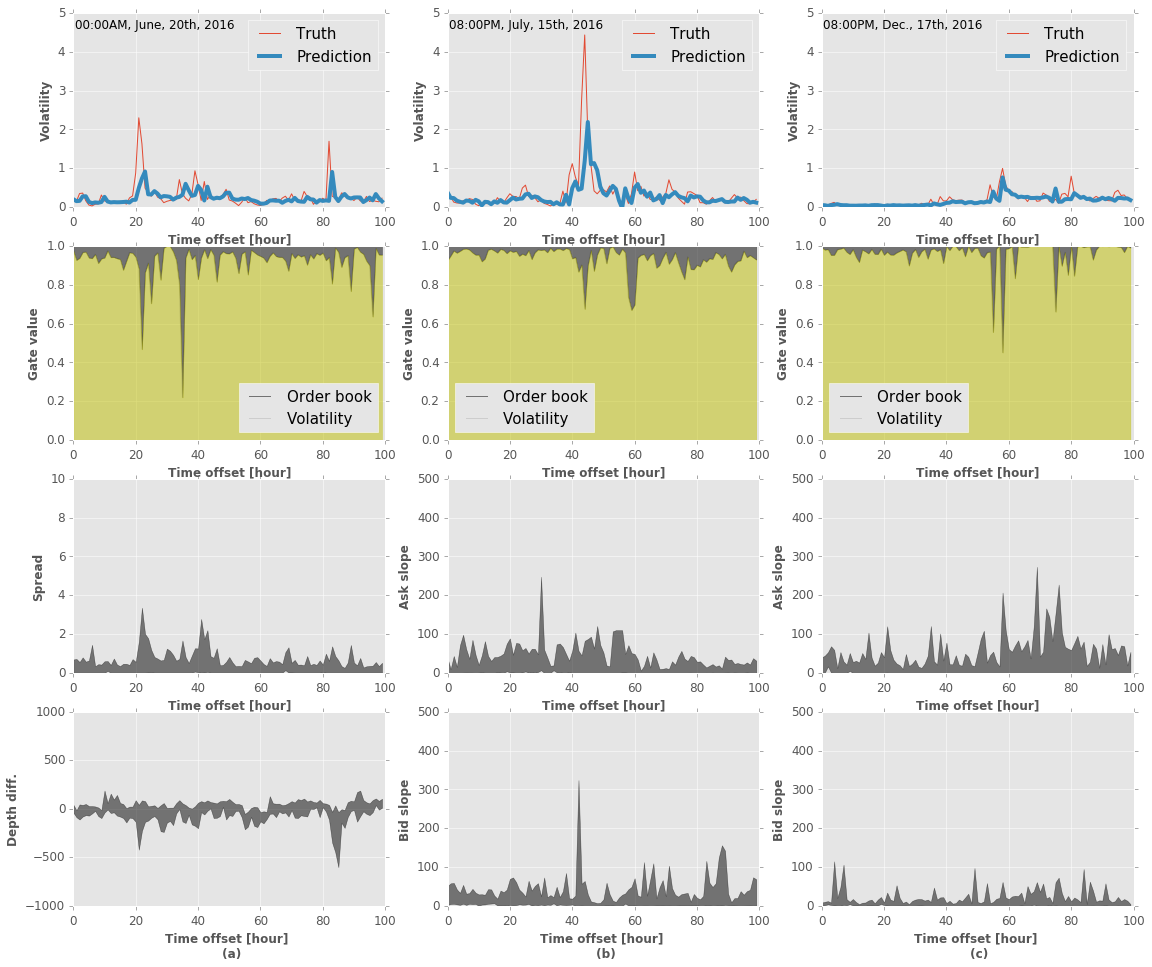

In [61]:
# final sample

y_range = [5, 5, 5]
feature_range = [ [ [0,10], [-1000, 1000] ], [ [0,500], [0,500] ], \
                  [ [0, 500], [0, 500] ] ]

sample_group( [ 9, 10, 15 ], [ [600, 700], [500, 600], [620, 720] ],\
              [ [0, 7], [9, 8], [9, 8] ], feature_range, y_range, range(5, 10) )

